# Churn rate prediction - part 2 - Modeling

Churn is a one of the biggest problem for business. Churn prediction can be utilised to improve retention rate by finding out who is likely to churn in the given period. Basically, the task is to predict whether a customer will stop using the services of the company.


In [73]:
# import libraries
from typing import Dict, Tuple
import warnings

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, model_selection, utils, metrics
import tensorflow as tf

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [87]:
data = pd.read_csv("../data/raw/Telco-Customer-Churn.csv")

## Data processing
### Convert/impute values

In [88]:
# help functions

def convert_to_binary(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    # transform Yes/No to binary
    binary_dict = {'Yes': 1, 'No': 0}
    df.loc[:, cols] = df[cols].stack().map(binary_dict).unstack()
    
    return df

def impute_mean(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    # impute means instead of nulls
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df.TotalCharges.fillna(value=np.mean(df[col]))
    return df

def gender_to_binary(df: pd.DataFrame) -> pd.DataFrame:
    # transform gender to binary
    gender_dict = {'Female': 1, 'Male': 0}
    df.loc[:, "gender"] = df.gender.map(gender_dict)
    
    return df
    
def convert_category(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    df = pd.get_dummies(data, columns=cols, drop_first=True)
    
    return df


In [89]:
data = convert_to_binary(data, ["PaperlessBilling", "PhoneService", "Dependents" ,"Partner", "Churn"])
data = impute_mean(data, ["TotalCharges"])
data = gender_to_binary(data)
data = convert_category(data, cols=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'])
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.50,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Features/labels transformation

In [90]:
data.set_index("customerID", inplace=True)
target = data.pop("Churn")
feature_matrix = data.values
print(f"The shape of the feature matrix is: {feature_matrix.shape}")
print(f"The shape of the labels is: {target.shape}")

The shape of the feature matrix is: (7043, 30)
The shape of the labels is: (7043,)


### Train/validation/test split

In [92]:
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(
    feature_matrix, target, train_size=0.8, random_state=42)

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_train_val, y_train_val, train_size=0.8, random_state=42)

### Normalization

In [94]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_val_scaled = scaler.transform(X_val)
X_val_scaled = np.expand_dims(X_val_scaled, axis=2)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

### class weight

In [95]:
class_weights = utils.class_weight.compute_class_weight(
    'balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.679583835946924, 1: 1.8921074727120066}

## Model

In [96]:
def cnn1d_model( input_shape: tuple,
                 filters: int = 32,
                 kernel_size: int = 10,
                 pool_size: int = 3,
                 dense_nodes: int = 32,
                 output_nodes: int = 1,
                 output_activation: str = 'sigmoid') -> tf.keras.Model:
    """Generates a tf model
    
    Parameters
    ----------
    input_shape: tuple
        the shape of the input
    filters: int, default 32
        the number of filters in the Conv1D layers
    kernel_size: int, default 10
    pool_size: int, default 3
    dense_nodes: int, default 32
        the number of nodes in the Dense layer before the last layer
    output_node: int, default 1
        the number of node in the output layer
    output_activation: str, default 'sigmoid'
        the activation function in the outpur layer
        
    Returns
    -------
    tf.keras.Model
        the tf model
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Conv1D(filters, kernel_size, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size),
        tf.keras.layers.Conv1D(filters, kernel_size, activation='relu', padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_nodes, activation='relu'),
        tf.keras.layers.Dense(output_nodes, activation=output_activation)
    ])
    return model

### Hyperparameter Tuning
#### Learning rate

In [98]:
# search for the optimal learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# define model
model = cnn1d_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), 
    filters=32, 
    kernel_size=3, 
    pool_size=2,
    dense_nodes=32
)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20)
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(lr=1e-6), 
    metrics=['accuracy'])

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100, 
    callbacks=[lr_schedule], 
    class_weight=class_weights
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-07-25 20:31:41.002123: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-25 20:31:41.080116: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
141/141 [==============================] - 1s 1ms/step - loss: 0.6771 - accuracy: 0.5203
Epoch 2/100
141/141 [==============================] - 0s 2ms/step - loss: 0.6752 - accuracy: 0.5325
Epoch 3/100
141/141 [==============================] - 0s 1ms/step - loss: 0.6732 - accuracy: 0.5474
Epoch 4/100
141/141 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.5662
Epoch 5/100
141/141 [==============================] - 0s 2ms/step - loss: 0.6686 - accuracy: 0.5869
Epoch 6/100
141/141 [==============================] - 0s 2ms/step - loss: 0.6661 - accuracy: 0.6071
Epoch 7/100
141/141 [==============================] - 0s 1ms/step - loss: 0.6633 - accuracy: 0.6268
Epoch 8/100
141/141 [==============================] - 0s 1ms/step - loss: 0.6604 - accuracy: 0.6446
Epoch 9/100
141/141 [==============================] - 0s 1ms/step - loss: 0.6573 - accuracy: 0.6565
Epoch 10/100
141/141 [==============================] - 0s 2ms/step - loss: 0.6539 - accura

141/141 [==============================] - 0s 2ms/step - loss: 0.4577 - accuracy: 0.7670
Epoch 82/100
141/141 [==============================] - 0s 1ms/step - loss: 0.4576 - accuracy: 0.7646
Epoch 83/100
141/141 [==============================] - 0s 2ms/step - loss: 0.4555 - accuracy: 0.7739
Epoch 84/100
141/141 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.7637
Epoch 85/100
141/141 [==============================] - 0s 1ms/step - loss: 0.4700 - accuracy: 0.7633
Epoch 86/100
141/141 [==============================] - 0s 1ms/step - loss: 0.4745 - accuracy: 0.7650
Epoch 87/100
141/141 [==============================] - 0s 1ms/step - loss: 0.4714 - accuracy: 0.7597
Epoch 88/100
141/141 [==============================] - 0s 1ms/step - loss: 0.4909 - accuracy: 0.7502
Epoch 89/100
141/141 [==============================] - 0s 1ms/step - loss: 0.5014 - accuracy: 0.7460
Epoch 90/100
141/141 [==============================] - 0s 1ms/step - loss: 0.5255 - accuracy: 

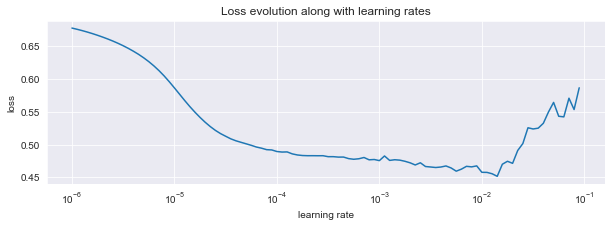

In [103]:
plt.figure(figsize=(10, 3))
plt.semilogx(history.history['lr'], history.history['loss'])
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.title("Loss evolution along with learning rates")
plt.show()

Select `1e-2` as the optimal learning rate.

#### filters, kernel_size, units

In [104]:
# search optimal values for other parameters
def model_builder(hp):
    """Defines the model builder for keras tuner
    """
    hp_filters = hp.Int('filters', min_value=16, max_value=64, step=16)
    hp_kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=1)
    hp_units = hp.Int('units', min_value=16, max_value=64, step=16)
    
    cnn_model = cnn1d_model(
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), 
        filters=hp_filters, 
        kernel_size=hp_kernel_size,
        pool_size=2,
        dense_nodes=hp_units
    )
    
    cnn_model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(), 
        optimizer=tf.keras.optimizers.Adam(lr=1e-4), 
        metrics=['accuracy'])
    return cnn_model

In [105]:
# build tuner
seed = 10

tuner = kt.BayesianOptimization(model_builder, 
                                objective='val_loss', 
                                max_trials=20,
                                seed=seed,
                                directory='./saved_models/churn_classifier/logs/', 
                                project_name='tuning_kt_bayes')

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode="auto",
        restore_best_weights=True,
    )

In [106]:
# searching
tuner.search(X_train_scaled, 
             y_train, 
             validation_data=(X_val_scaled, y_val),
             epochs=500, 
             callbacks=[early_stopping], 
             class_weight=class_weights, 
             verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nThe best hyperparameters are:")
print(f"\tFilter: {best_hps.get('filters')}")
print(f"\tKernel_size: {best_hps.get('kernel_size')}")
print(f"\tUnits: {best_hps.get('units')}")

Trial 20 Complete [00h 00m 06s]
val_loss: 0.46874165534973145

Best val_loss So Far: 0.45961275696754456
Total elapsed time: 00h 02m 47s
INFO:tensorflow:Oracle triggered exit

The best hyperparameters are:
	Filter: 64
	Kernel_size: 5
	Units: 48


### Best model selection

In [107]:
# training model
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

opt_cnn_model = cnn1d_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), 
    filters=64, 
    kernel_size=4,
    pool_size=2,
    dense_nodes=16
)

opt_cnn_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(lr=1e-4), 
    metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

opt_cnn_model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=500, 
    callbacks=[early_stopping], 
    class_weight=class_weights)

Epoch 1/500
141/141 [==============================] - 1s 3ms/step - loss: 0.5975 - accuracy: 0.7351 - val_loss: 0.5233 - val_accuracy: 0.7258
Epoch 2/500
141/141 [==============================] - 0s 2ms/step - loss: 0.5157 - accuracy: 0.7306 - val_loss: 0.5034 - val_accuracy: 0.7445
Epoch 3/500
141/141 [==============================] - 0s 2ms/step - loss: 0.5017 - accuracy: 0.7382 - val_loss: 0.5075 - val_accuracy: 0.7382
Epoch 4/500
141/141 [==============================] - 0s 2ms/step - loss: 0.4957 - accuracy: 0.7413 - val_loss: 0.4827 - val_accuracy: 0.7569
Epoch 5/500
141/141 [==============================] - 0s 3ms/step - loss: 0.4924 - accuracy: 0.7415 - val_loss: 0.4704 - val_accuracy: 0.7622
Epoch 6/500
141/141 [==============================] - 0s 2ms/step - loss: 0.4905 - accuracy: 0.7415 - val_loss: 0.4827 - val_accuracy: 0.7524
Epoch 7/500
141/141 [==============================] - 0s 3ms/step - loss: 0.4885 - accuracy: 0.7433 - val_loss: 0.5147 - val_accuracy: 0.7285

## Model Evaluation

In [108]:
y_pred_train = opt_cnn_model.predict(X_train_scaled)
y_pred_train = y_pred_train > 0.5
print("Training set")
print(metrics.classification_report(y_train, y_pred_train))
print()

y_pred_val = opt_cnn_model.predict(X_val_scaled)
y_pred_val = y_pred_val > 0.5
print("Validation set")
print(metrics.classification_report(y_val, y_pred_val))

y_pred_test = opt_cnn_model.predict(X_test_scaled)
y_pred_test = y_pred_test > 0.5
print("Test set")
print(metrics.classification_report(y_test, y_pred_test))

Training set
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      3316
           1       0.53      0.76      0.63      1191

    accuracy                           0.76      4507
   macro avg       0.72      0.76      0.73      4507
weighted avg       0.80      0.76      0.77      4507


Validation set
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       822
           1       0.54      0.75      0.62       305

    accuracy                           0.76      1127
   macro avg       0.71      0.75      0.72      1127
weighted avg       0.79      0.76      0.77      1127

Test set
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1036
           1       0.56      0.81      0.66       373

    accuracy                           0.78      1409
   macro avg       0.74      0.79      0.75      1409
weighted avg       0.82      0.78   